In [1]:
%matplotlib inline
import sys
import math
import numpy as np
import pandas
from matplotlib import pyplot
from mosthosts_desi import MostHostsDesi

## Finding all DESI observations of MostHosts objects

The MostHostsDesi class will match all of the RA/Dec from Mosthosts to the daily tables of observations from DESI.  It builds a (somewhat complicated) Pandas datastructure with all of the matches, and then writes that data structure to a csv file.  Look at that file for documentation on how it works.

In [2]:
# To actually use this, you'll need to pass a database user and password.
# See the docstring on MostHostsDesi.__init__ for more information.
# Release can be "daily" or "everest"
# By default, this reads mosthosts_desi_{release}.csv from the local
#   directory.  Set force_regen=True to make it rebuild that file.
subset = "daily"
mhd = MostHostsDesi( release=subset, force_regen=False)

[2022-02-23 14:22:09,211 - WARNING] - Building mosthosts_desi_daily.csv and mosthosts_desi_daily_desiobs.csv from database.
[2022-02-23 14:22:09,225 - INFO] - Loading mosthosts table...
[2022-02-23 14:22:10,164 - INFO] - ...mosthosts table loaded.
[2022-02-23 14:22:10,165 - INFO] - Done 0 of 20174 hosts; 0 hosts have redshifts, found a total of 0 redshifts
[2022-02-23 14:22:27,542 - INFO] - Done 1000 of 20174 hosts; 151 hosts have redshifts, found a total of 198 redshifts
[2022-02-23 14:22:41,028 - INFO] - Done 2000 of 20174 hosts; 347 hosts have redshifts, found a total of 436 redshifts
[2022-02-23 14:22:54,864 - INFO] - Done 3000 of 20174 hosts; 517 hosts have redshifts, found a total of 641 redshifts
[2022-02-23 14:23:09,568 - INFO] - Done 4000 of 20174 hosts; 818 hosts have redshifts, found a total of 988 redshifts
[2022-02-23 14:23:25,852 - INFO] - Done 5000 of 20174 hosts; 1194 hosts have redshifts, found a total of 1487 redshifts
[2022-02-23 14:23:41,135 - INFO] - Done 6000 of 2

In [3]:
# Print out some statistics
print( f'...as of when the csv and pkl files were last regenerated:' )
print( f'{len(mhd.df)} entries in the MostHosts database' )
print( f'{len(mhd.df.groupby("snname"))} different SNe/AGN in MostHosts database' )
print( f'{mhd.df["z"].notnull().sum()} hosts have at least one DESI zwarn=0 redshift' )
print( f'{len( mhd.df[ mhd.df["z"].notnull() ].groupby( "snname" ) )} SNe/AGN have at least one host observed by DESI' )
# I put this here as a self-consistency check between my two dataframes
print( f'The same number again: {len( mhd.haszdf[ mhd.haszdf["zwarn"]==0 ].reset_index().groupby( "snname" ) )}' )

# Make a dataframe that's like df, but that omits all QSOs and that all have at least one redshift
print( '' )
justsne = mhd.haszdf[ mhd.haszdf['zwarn']==0 ]
justsne = justsne[ justsne['program'].apply( lambda x: 'QSO' not in x ) ]
print( f'{len( justsne.reset_index().groupby( ["snname", "index"] ))} non-QSO MostHosts have at least one DESI observation' )
print( f'{len( justsne.reset_index().groupby( "snname" ))} SNe (i.e. non-QSO targets) have at least one host observed by DESI' )


...as of when the csv and pkl files were last regenerated:
20174 entries in the MostHosts database
14958 different SNe/AGN in MostHosts database
3449 hosts have at least one DESI zwarn=0 redshift
3349 SNe/AGN have at least one host observed by DESI
The same number again: 3349

2732 non-QSO MostHosts have at least one DESI observation
2632 SNe (i.e. non-QSO targets) have at least one host observed by DESI


In [4]:
# If you want to figure out which supernovae have multiple hosts, you can poke at the mhd.df dataframe similar to the following

origtablehostcount = mhd.df.reset_index().groupby( "snname" ).count()["index"]
for i in range( 1, 8 ):
    print( f'{(origtablehostcount == i).sum()} candidates in the mosthosts table have {i} hosts' )
# print( f'The candidates with 3 observed hosts are: {origtablehostcount[origtablehostcount == 5].index.values}' )

print( '' )

obshostcount = mhd.df[ mhd.df['z'].notnull() ].reset_index().groupby( "snname" ).count()["index"]
for i in range( 1, 8 ):
    print( f'{(obshostcount == i).sum()} candidates have {i} hosts observed by DESI with zwarn=0' )

11240 candidates in the mosthosts table have 1 hosts
2367 candidates in the mosthosts table have 2 hosts
1217 candidates in the mosthosts table have 3 hosts
123 candidates in the mosthosts table have 4 hosts
10 candidates in the mosthosts table have 5 hosts
0 candidates in the mosthosts table have 6 hosts
1 candidates in the mosthosts table have 7 hosts

3257 candidates have 1 hosts observed by DESI with zwarn=0
85 candidates have 2 hosts observed by DESI with zwarn=0
6 candidates have 3 hosts observed by DESI with zwarn=0
1 candidates have 4 hosts observed by DESI with zwarn=0
0 candidates have 5 hosts observed by DESI with zwarn=0
0 candidates have 6 hosts observed by DESI with zwarn=0
0 candidates have 7 hosts observed by DESI with zwarn=0


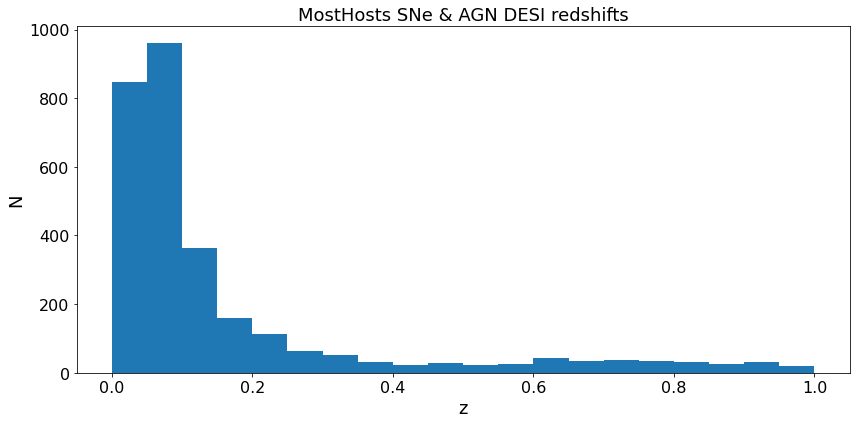

In [5]:
# Make a histogram of independent supernova z and AGN.  The host z might not be the right one, as
#   the plot just naively grabs the first host listed for each SN.

subframe = mhd.df[ mhd.df['z'].notnull() ].groupby( 'snname' ).agg('first')

# Let's make a histogram of those zs
fig = pyplot.figure( figsize=(12,6), tight_layout=True )
ax = fig.add_subplot(1, 1, 1)
ax.hist( subframe['z'], range=(0,1), bins=20)
ax.set_xlabel('z', fontsize=18)
ax.set_ylabel('N', fontsize=18)
ax.set_title( 'MostHosts SNe & AGN DESI redshifts', fontsize=18 )
#ax.set_yscale('log')
ax.tick_params( axis='both', labelsize=16 )
fig.show()
fig.savefig( f'mosthostsz_{subset}.svg' )


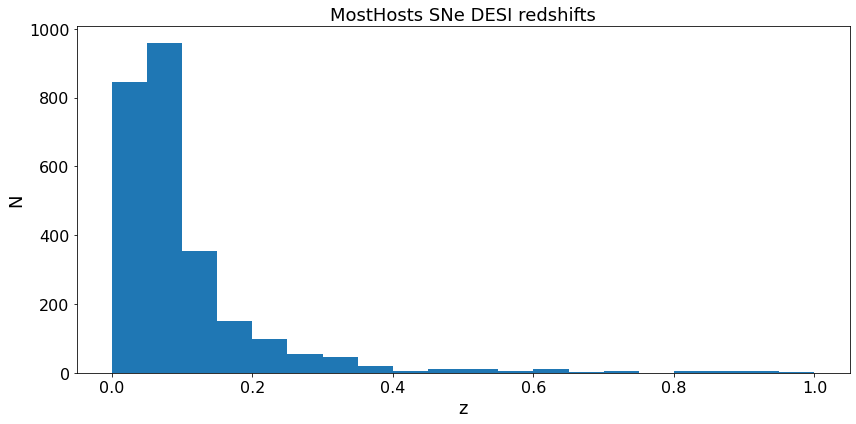

In [6]:
# Make a histogram of *independent* supernova zs.  I'm just going to take the first measurement
#  for each supernova... which may well not be the right one!

subframe = justsne.groupby( 'snname' ).agg('first')

# Let's make a histogram of those zs
fig = pyplot.figure( figsize=(12,6), tight_layout=True )
ax = fig.add_subplot(1, 1, 1)
ax.hist( subframe['z'], range=(0,1), bins=20)
ax.set_xlabel('z', fontsize=18)
ax.set_ylabel('N', fontsize=18)
ax.set_title( 'MostHosts SNe DESI redshifts', fontsize=18 )
#ax.set_yscale('log')
ax.tick_params( axis='both', labelsize=16 )
fig.show()
fig.savefig( f'mosthosts_justsnez_{subset}.svg' )


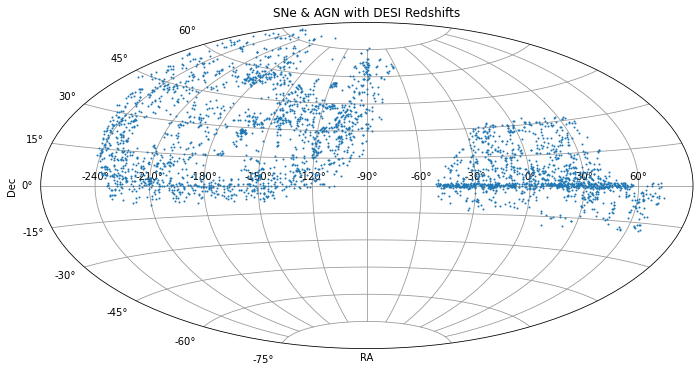

In [7]:
# Plot them on the sky

subframe = mhd.df[ mhd.df['z'].notnull() ].groupby( 'snname' ).agg('first')


fig = pyplot.figure( figsize=(12,6) )
ax = fig.add_subplot(1, 1, 1, projection='aitoff' )
# I want to plot the aitoff projection not having 0 at the center
# I don't know if there's a simple argument to give to the axes for
# this, so I'll manually offset my RAs, and then manually edit the
# tick labels, to offset by raoff degrees.
raoff = 90
ras = ( subframe['ra'].values + raoff ) * math.pi/180.
ras[ ras < -math.pi ] = ras[ ras < -math.pi ] + 2*math.pi
ras[ ras >= math.pi ] = ras[ ras >= math.pi ] - 2*math.pi
ax.set_longitude_grid( 30 )
ax.set_latitude_grid( 15 )
ax.grid( which='major', color='#999999' )
ax.plot( ras, subframe['dec'].values*math.pi/180., linestyle='None', marker='o', markersize=1 )
fig.canvas.draw()
labels = [ f'{float(lab.get_text()[:-1])-raoff:.0f}°' for lab in ax.get_xticklabels() ]
ax.set_xticklabels( labels )
# Remove the 75° label so it doesn't overlap the title.
# THere's probably a more elegant way to do this.
labels = [ lab for lab in ax.get_yticklabels()[:-1] ] + ['']
ax.set_yticklabels( labels )
ax.set_xlabel( "RA" )
ax.set_ylabel( "Dec" )
ax.set_title( "SNe & AGN with DESI Redshifts" )
fig.show()
fig.savefig( f'mosthostdesiz_skydist_{subset}.svg' )

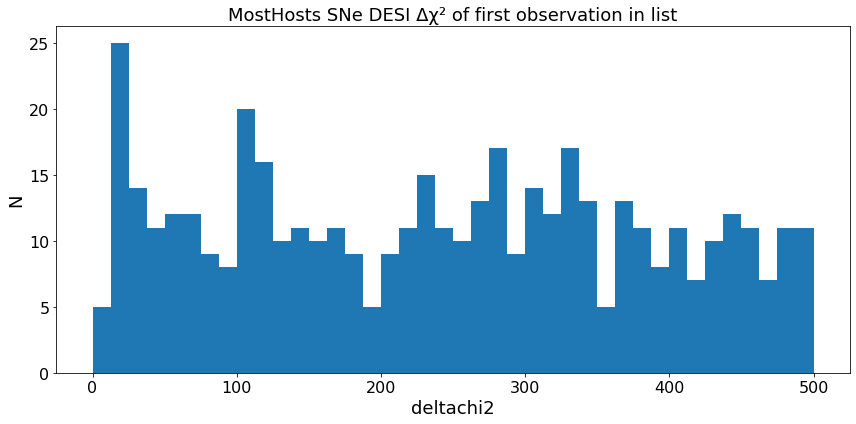

In [8]:
subframe = justsne.groupby( 'snname' ).agg('first')

fig = pyplot.figure( figsize=(12,6), tight_layout=True )
ax = fig.add_subplot(1, 1, 1)
ax.hist( subframe['deltachi2'].values, range=(0,500), bins=40)
ax.set_xlabel('deltachi2', fontsize=18)
ax.set_ylabel('N', fontsize=18)
ax.set_title( 'MostHosts SNe DESI Δχ² of first observation in list', fontsize=18 )
#ax.set_yscale('log')
ax.tick_params( axis='both', labelsize=16 )
fig.show()


In [9]:
subframe = justsne.groupby( 'snname' ).agg('first')
dexes = subframe.index.values
ztfobjs = subframe[ [ it[0:3]=='ZTF' for it in dexes ] ]
# I know I could have done a pandas count something something,
# but I might want this subframe later.
print( f"There are {len(ztfobjs)} SNe with DESI-observed hosts whose names start with \"ZTF\"" )

There are 1413 SNe with DESI-observed hosts whose names start with "ZTF"


In [10]:
ztfobjs[ ['z', 'ra', 'dec' ] ]

,z,ra,dec
snname,,,
ZTF17aaaiwbs,0.326757,127.792220,6.273444
ZTF17aabxonw,0.290645,178.779339,52.030977
ZTF17testa,0.710282,148.283602,14.981531
ZTF18aaabiok,0.000028,121.876380,15.570784
ZTF18aaajrso,0.075372,206.000078,30.932117
...,...,...,...
ZTF20aciugdl,0.081775,124.996098,7.796544
ZTF20acizlhn,0.297178,353.552710,7.350086
ZTF20acizliy,0.042701,348.405277,4.149287


In [11]:
ztfobjs['program'].unique()

array(['SNe_Ia', 'ZTFmarshal', 'SNe_Ia/ZTFmarshal', 'RCF',
       'RCF/ZTFmarshal', 'SNe_Ia/RCF/ZTFmarshal', 'IIps/ZTFmarshal',
       'SNe_Ia/RCF', 'RCF/IIps/ZTFmarshal', 'SNe_Ia/IIps/ZTFmarshal',
       'SNe_Ia/RCF/Anna', 'SNe_Ia/RCF/IIps/ZTFmarshal', 'Anna/ZTFmarshal',
       'RCF/RCF/RCF/ZTFmarshal/ZTFmarshal', 'one_shot_dL'], dtype=object)

In [12]:
# ztfobjs['program'].values is an object, not a string, so this is convolted
ztfsne = ztfobjs[ np.char.find( np.array( ztfobjs['program'].values, dtype=str ), 'SNe_Ia' ) >= 0 ]
print( f'There are {len(ztfsne)} SNe with program including "SNe_Ia" that are observed by DESI and that have names starting with "ZTF"' )

There are 576 SNe with program including "SNe_Ia" that are observed by DESI and that have names starting with "ZTF"


In [13]:
justptf = justsne[ justsne['ptfiptf_name'] != 'None' ]
print( f'There are {len(justptf)} SNe with a non-"None" ptfiptf_name' )

There are 568 SNe with a non-"None" ptfiptf_name


In [14]:
pandas.options.display.max_rows = 500
justptf[ ['ptfiptf_name', 'ra', 'dec', 'z'] ]

ptfiptf_name          ra  \
snname index targetid          tileid petal night                               
09alu  1     39633304558764813 174    4     20210405     PTF09alu  214.572816   
                               182    4     20210506     PTF09alu  214.572816   
09aus  1     39627782463952435 20094  3     20210609     PTF09aus  225.231327   
09bad  2     39633339597983311 318    6     20210501     PTF09bad  244.010525   
09bw   1     39633228843189320 20771  6     20210618      PTF09bw  226.247542   
...                                                           ...         ...   
15wd   1     39633321822522160 20595  2     20220218     iPTF15wd  174.725250   
15wk   1     39628243766084410 24481  9     20211016     iPTF15wk  128.766206   
                                            20211021     iPTF15wk  128.766206   
15xc   1     39632945849304349 21175  0     20210516     iPTF15xc  186.079167   
15zr   1     39633311340954958 81066  0     20210326     iPTF15zr  179.745833   

                                                            dec         z  
snname index targetid          tileid petal night                          
09alu  1     39633304558764813 174    4     20210405  53.788987  0.074413  
                               182    4     20210506  53.788987  0.074455  
09aus  1     39627782463952435 20094  3     20210609  -0.192354  0.041126  
09bad  2     39633339597983311 318    6     20210501  56.346198  0.138984  
09bw   1     39633228843189320 20771  6     20210618  48.646639  0.024453  
...                                                         ...       ...  
15wd   1     39633321822522160 20595  2     20220218  55.057643  0.057340  
15wk   1     39628243766084410 24481  9     20211016  19.185778  0.209298  
                                            20211021  19.185778  0.208930  
15xc   1     39632945849304349 21175  0     20210516  33.183806  0.021921  
15zr   1     39633311340954958 81066  0     20210326  54.239028  0.012237  

[568 rows x 4 columns]